# Inference example for trained 2D U-Net model on BraTS.
Takes a trained model and performs inference on a few validation examples.

In [1]:
import sys
import platform
import os

print("Python version: {}".format(sys.version))
print("{}".format(platform.platform()))

Python version: 3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]
Linux-5.11.0-051100rc5-generic-x86_64-with-debian-buster-sid


In [2]:
def test_intel_tensorflow():
    """
    Check if Intel version of TensorFlow is installed
    """
    import tensorflow as tf
    
    print("We are using Tensorflow version {}".format(tf.__version__))
           
    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
       from tensorflow.python import _pywrap_util_port
       print("Intel-optimizations (DNNL) enabled:", _pywrap_util_port.IsMklEnabled())
    else:
       print("Intel-optimizations (DNNL) enabled:", tf.pywrap_tensorflow.IsMklEnabled()) 

test_intel_tensorflow()

We are using Tensorflow version 2.4.1
Intel-optimizations (DNNL) enabled: True


In [3]:
saved_model_dir = "./output/2d_unet_decathlon"

In [4]:
# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)
    
model_filename = os.path.join(saved_model_dir)

#### Define the DICE coefficient and loss function

The Sørensen–Dice coefficient is a statistic used for comparing the similarity of two samples. Given two sets, X and Y, it is defined as

\begin{equation}
dice = \frac{2|X\cap Y|}{|X|+|Y|}
\end{equation}

In [5]:
import numpy as np

def calc_dice(target, prediction, smooth=0.0001):
    """
    Sorensen Dice coefficient
    """
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

def calc_soft_dice(target, prediction, smooth=0.0001):
    """
    Sorensen (Soft) Dice coefficient - Don't round predictions
    """
    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

## Inference Time!

Inferencing in this example can be done in 3 simple steps:
1. Load the data
1. Load the Keras model 
1. Perform a `model.predict` on an input image (or set of images)

#### Step 1 : Load data

In [6]:
data_path = "/data/medical_decathlon/Task01_BrainTumour/"

crop_dim=128  # Original resolution (240)
batch_size = 128
seed=816
train_test_split=0.85

In [7]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_test = DatasetGenerator(testFiles, 
                           batch_size=batch_size, 
                           crop_dim=[crop_dim, crop_dim], 
                           augment=False, 
                           seed=seed)


******************************
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 411
Number of validation files = 36
Number of testing files    = 37


#### Step 2 : Load the model

In [8]:
from model import unet

from tensorflow import keras as K
model = K.models.load_model(saved_model_dir, compile=False, custom_objects=unet().custom_objects)

Data format = channels_last


#### Step 3: Perform prediction on some images. 
The prediction results will be saved in the output directory for images, which is defined by the `png_directory` variable.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import time

def plot_results(ds):
    
    plt.figure(figsize=(10,10))

    img, msk = next(ds.ds)

    idx = np.argmax(np.sum(np.sum(msk[:,:,:,0], axis=1), axis=1)) # find the slice with the largest tumor

    plt.subplot(1, 3, 1)
    plt.imshow(img[idx, :, :, 0], cmap="bone", origin="lower")
    plt.title("MRI {}".format(idx), fontsize=20)

    plt.subplot(1, 3, 2)
    plt.imshow(msk[idx, :, :], cmap="bone", origin="lower")
    plt.title("Ground truth", fontsize=20)

    plt.subplot(1, 3, 3)

    print("Index {}: ".format(idx), end="")
    
    # Predict using the TensorFlow model
    start_time = time.time()
    prediction = model.predict(img[[idx]])
    print("Elapsed time = {:.4f} msecs, ".format(1000.0*(time.time()-start_time)), end="")
    
    plt.imshow(prediction[0,:,:,0], cmap="bone", origin="lower")
    dice_coef = calc_dice(msk[idx], prediction)
    print("Dice coefficient = {:.4f}, ".format(dice_coef), end="")
    plt.title("Prediction\nDice = {:.4f}".format(dice_coef), fontsize=20)


Index 72: Elapsed time = 860.7397 msecs, Dice coefficient = 0.7959, 

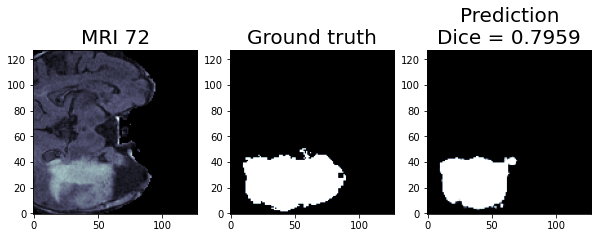

In [10]:
plot_results(ds_test)

Index 121: Elapsed time = 145.4611 msecs, Dice coefficient = 0.6989, 

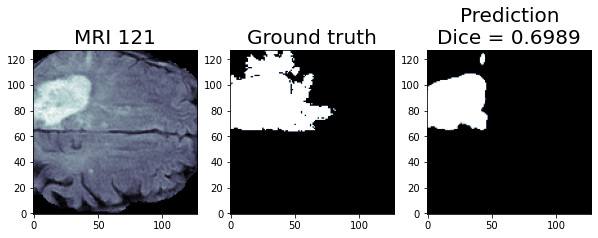

In [11]:
plot_results(ds_test)

Index 0: Elapsed time = 271.1916 msecs, Dice coefficient = 0.8434, 

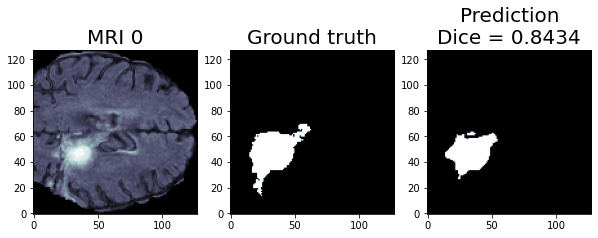

In [12]:
plot_results(ds_test)

Index 74: Elapsed time = 168.3469 msecs, Dice coefficient = 0.9225, 

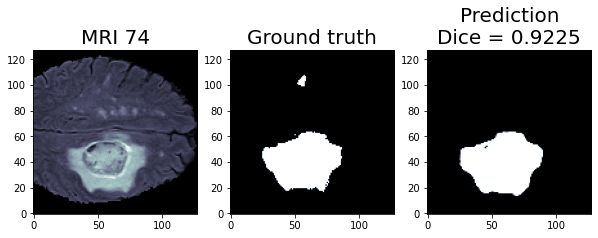

In [13]:
plot_results(ds_test)

Index 56: Elapsed time = 148.7539 msecs, Dice coefficient = 0.8492, 

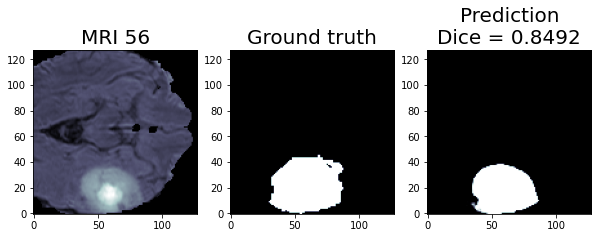

In [14]:
plot_results(ds_test)

Index 89: Elapsed time = 87.6770 msecs, Dice coefficient = 0.9478, 

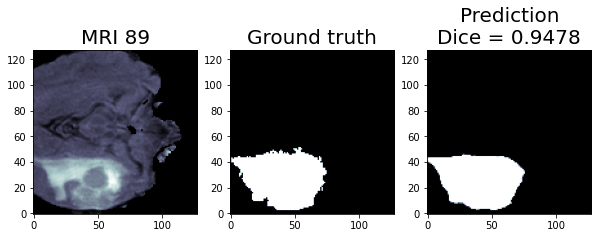

In [15]:
plot_results(ds_test)

Index 115: Elapsed time = 89.2231 msecs, Dice coefficient = 0.9539, 

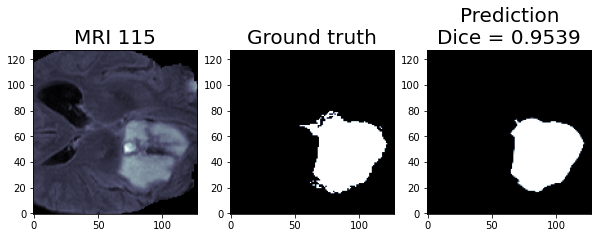

In [16]:
plot_results(ds_test)

# Can we perform inference even faster? Hmm..

Let's find out. Move on the the next tutorial section.

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*